# 🛠️ Tools support

<a href="https://colab.research.google.com/github/deepset-ai/haystack-experimental/blob/main/examples/tools_support.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" width="200"/></a>

In this notebook, we introduce the experimental features we've been developing for tool/function calling support in Haystack.

*Experimental means that these features are accessible in `haystack_experimental`, are open to feedback, and are subject to change.*

- We refactored the `ChatMessage` dataclass, to be more flexible and future-proof.
- We introduced some new dataclasses: `ToolCall`, `ToolCallResult`, and `Tool`.
- We added support for tools in the `OpenAIChatGenerator` (and more to come).
- We introduced the `ToolInvoker` component, to actually execute tool calls prepared by Language Models.

We will first introduce the new features and then show three end-to-end examples:
- A basic assistant that can answer user questions by either using a weather tool or relying on its own knowledge.
- A refined version of the assistant that can process the tool's output further before presenting it to the user.
- A chat application that can use multiple tools, with Human-in-the-Loop interaction to gather additional input from the user when needed.

In [ ]:
! pip install haystack-ai "sentence-transformers>=3.0.0"

In [15]:
import os
from getpass import getpass
from rich import print

if "OPENAI_API_KEY" not in os.environ:
  os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

## New experimental features

### Refactored `ChatMessage` dataclass, `ToolCall`, and `ToolCallResult`

The `ChatMessage` dataclass has been updated so that the `content` field is no longer just a string (`str`); it is now a list that can hold various types, including `TextContent`, `ToolCall`, and `ToolCallResult`.

The class methods `from_user`, `from_system`, `from_assistant`, and `from_tool` (newly added) are the recommended ways to create `ChatMessage` instances.

Additionally, we introduced:
- `ToolCall` dataclass: represents a tool call prepared by a Language Model.
- `ToolCallResult` dataclass: represents the result of a tool invocation.

Let's see some examples.

In [16]:
from haystack_experimental.dataclasses import ChatMessage, ToolCall

user_message = ChatMessage.from_user("What is the capital of Australia?")
print(user_message)

print(user_message.text)
print(user_message.texts)

print(user_message.tool_call)
print(user_message.tool_calls)

print(user_message.tool_call_result)
print(user_message.tool_call_results)

ChatMessage(
    _role=<ChatRole.USER: 'user'>,
    _content=[TextContent(text='What is the capital of Australia?')],
    _meta={}
)

What is the capital of Australia?

['What is the capital of Australia?']

None

[]

None

[]

In [17]:
assistant_message = ChatMessage.from_assistant("How can I assist you today?")
print(assistant_message)

print(assistant_message.text)
print(assistant_message.texts)

print(assistant_message.tool_call)
print(assistant_message.tool_calls)

print(assistant_message.tool_call_result)
print(assistant_message.tool_call_results)

ChatMessage(
    _role=<ChatRole.ASSISTANT: 'assistant'>,
    _content=[TextContent(text='How can I assist you today?')],
    _meta={}
)

How can I assist you today?

['How can I assist you today?']

None

[]

None

[]

In [18]:
tool_call = ToolCall(tool_name="weather_tool", arguments={"location": "Rome"})

assistant_message_w_tool_call = ChatMessage.from_assistant(tool_calls=[tool_call])

print(assistant_message_w_tool_call.text)
print(assistant_message_w_tool_call.texts)

print(assistant_message_w_tool_call.tool_call)
print(assistant_message_w_tool_call.tool_calls)

print(assistant_message_w_tool_call.tool_call_result)
print(assistant_message_w_tool_call.tool_call_results)

None

[]

ToolCall(tool_name='weather_tool', arguments={'location': 'Rome'}, id=None)

[ToolCall(tool_name='weather_tool', arguments={'location': 'Rome'}, id=None)]

None

[]

In [19]:
tool_message = ChatMessage.from_tool(tool_result="temperature: 25°C", origin=tool_call, error=False)

print(tool_message.text)
print(tool_message.texts)

print(tool_message.tool_call)
print(tool_message.tool_calls)

print(tool_message.tool_call_result)
print(tool_message.tool_call_results)

None

[]

None

[]

ToolCallResult(
    result='temperature: 25°C',
    origin=ToolCall(tool_name='weather_tool', arguments={'location': 'Rome'}, id=None),
    error=False
)

[
    ToolCallResult(
        result='temperature: 25°C',
        origin=ToolCall(tool_name='weather_tool', arguments={'location': 'Rome'}, id=None),
        error=False
    )
]

### `Tool` dataclass

This represents a tool for which Language Models can prepare a call.

It has the following attributes:
- `name`
- `description`
- `parameters`: a JSON schema describing the expected parameters
- `function`: a callable that is invoked when the tool is called

Accurate definitions of the textual attributes such as `name` and `description` are important for the Language Model to correctly prepare the call.

`Tool` exposes a `tool_spec` property, returning the tool specification to be used by Language Models.

It also has an `invoke` method that executes the underlying function with the provided parameters.

*Future enhancements may include automatic tool definition from function signatures.*

Let's see an example.

In [20]:
from haystack_experimental.dataclasses import Tool

def add(a: int, b: int) -> int:
    return a + b


parameters = {
    "type": "object",
    "properties": {
        "a": {"type": "integer"},
        "b": {"type": "integer"}
    },
    "required": ["a", "b"]
}

add_tool = Tool(name="addition_tool",
            description="This tool adds two numbers",
            parameters=parameters,
            function=add)

print(add_tool.tool_spec)

print(add_tool.invoke(a=15, b=10))

{
    'name': 'addition_tool',
    'description': 'This tool adds two numbers',
    'parameters': {
        'type': 'object',
        'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}},
        'required': ['a', 'b']
    }
}

25

### Support for tools in `OpenAIChatGenerator`

The OpenAIChatGenerator now supports tools. You can pass tools during initialization or via the run method, and it will use them to prepare tool calls when appropriate.

*As we expand support for tools in other chat generators, you can already experiment with the OpenAIChatGenerator and OpenAI-compatible libraries like Ollama or llama.cpp.*

Here are some examples.

In [21]:
from haystack_experimental.components.generators.chat import OpenAIChatGenerator

# Initialize the Chat Generator with the addition tool
chat_generator = OpenAIChatGenerator(model="gpt-4o-mini", tools=[add_tool])

res=chat_generator.run([ChatMessage.from_user("10 + 238")])
print(res)

res=chat_generator.run([ChatMessage.from_user("What is the habitat of a lion?")])
print(res)

{
    'replies': [
        ChatMessage(
            _role=<ChatRole.ASSISTANT: 'assistant'>,
            _content=[
                ToolCall(
                    tool_name='addition_tool',
                    arguments={'a': 10, 'b': 238},
                    id='call_rbYtbCdW0UbWMfy2x0sgF1Ap'
                )
            ],
            _meta={
                'model': 'gpt-4o-mini-2024-07-18',
                'index': 0,
                'finish_reason': 'tool_calls',
                'usage': {'completion_tokens': 19, 'prompt_tokens': 51, 'total_tokens': 70}
            }
        )
    ]
}

{
    'replies': [
        ChatMessage(
            _role=<ChatRole.ASSISTANT: 'assistant'>,
            _content=[
                TextContent(
                    text='Lions primarily inhabit grasslands, savannas, and open woodlands. They are generally 
found in sub-Saharan Africa, where they prefer areas that provide ample prey and suitable shelter. Historically, 
lions were also present in parts of Europe and Asia, but their range has significantly diminished, and they are now
largely confined to Africa. The presence of water sources and accessible prey are critical factors in their habitat
selection.'
                )
            ],
            _meta={
                'model': 'gpt-4o-mini-2024-07-18',
                'index': 0,
                'finish_reason': 'stop',
                'usage': {'completion_tokens': 84, 'prompt_tokens': 55, 'total_tokens': 139}
            }
        )
    ]
}

In [22]:
# Initialize the Chat Generator without tools
chat_generator = OpenAIChatGenerator(model="gpt-4o-mini")

res=chat_generator.run([ChatMessage.from_user("10 + 238")])
print(res)

# pass tools in the run method: in this case, the model will prepare a tool call
res_w_tool_call=chat_generator.run([ChatMessage.from_user("10 + 238")], tools=[add_tool])
print(res_w_tool_call)

{
    'replies': [
        ChatMessage(
            _role=<ChatRole.ASSISTANT: 'assistant'>,
            _content=[TextContent(text='10 + 238 = 248.')],
            _meta={
                'model': 'gpt-4o-mini-2024-07-18',
                'index': 0,
                'finish_reason': 'stop',
                'usage': {'completion_tokens': 8, 'prompt_tokens': 11, 'total_tokens': 19}
            }
        )
    ]
}

{
    'replies': [
        ChatMessage(
            _role=<ChatRole.ASSISTANT: 'assistant'>,
            _content=[
                ToolCall(
                    tool_name='addition_tool',
                    arguments={'a': 10, 'b': 238},
                    id='call_GaVZnGszepASznKpYVe23mHf'
                )
            ],
            _meta={
                'model': 'gpt-4o-mini-2024-07-18',
                'index': 0,
                'finish_reason': 'tool_calls',
                'usage': {'completion_tokens': 19, 'prompt_tokens': 51, 'total_tokens': 70}
            }
        )
    ]
}

### `ToolInvoker` component

This component is responsible for executing tool calls prepared by Language Models.
It expects a list of messages (which may include tool calls) and returns a list of tool messages, containing the results of the tool invocations.

In [23]:
from haystack_experimental.components.tools import ToolInvoker

# Initialize the Tool Invoker with the weather tool
tool_invoker = ToolInvoker(tools=[add_tool])

# let's pass the messages from the previous example
print(tool_invoker.run(res_w_tool_call["replies"]))

{
    'tool_messages': [
        ChatMessage(
            _role=<ChatRole.TOOL: 'tool'>,
            _content=[
                ToolCallResult(
                    result='248',
                    origin=ToolCall(
                        tool_name='addition_tool',
                        arguments={'a': 10, 'b': 238},
                        id='call_GaVZnGszepASznKpYVe23mHf'
                    ),
                    error=False
                )
            ],
            _meta={}
        )
    ]
}

`ToolInvoker` has 2 additional init parameters:
- `raise_on_failure`: if True, the component raises an exception in case of errors (tool not found, tool invocation errors, tool result conversion errors). Otherwise, it returns a `ChatMessage` object with `error=True` and a description of the error in `result`.
- `convert_result_to_json_string`: if True, the tool invocation result will be converted to a string using `json.dumps`. If False, converts the result using `str` (default).

Let's see how `raise_on_failure` works.

In [24]:
tool_call = ToolCall(tool_name="division_tool", arguments={"c": 1, "d": 2})

tool_invoker = ToolInvoker(tools=[add_tool], raise_on_failure=True)

tool_invoker.run([ChatMessage.from_assistant(tool_calls=[tool_call])])

ToolNotFoundException: Tool division_tool not found in the list of tools. Available tools are: dict_keys(['addition_tool']).

In [26]:
tool_invoker = ToolInvoker(tools=[add_tool], raise_on_failure=False)

print(tool_invoker.run([ChatMessage.from_assistant(tool_calls=[tool_call])]))

{
    'tool_messages': [
        ChatMessage(
            _role=<ChatRole.TOOL: 'tool'>,
            _content=[
                ToolCallResult(
                    result="Tool division_tool not found in the list of tools. Available tools are: 
dict_keys(['addition_tool']).",
                    origin=ToolCall(tool_name='division_tool', arguments={'c': 1, 'd': 2}, id=None),
                    error=True
                )
            ],
            _meta={}
        )
    ]
}

## End-to-end examples

In this section, we’ll put together everything we've covered so far into some practical, end-to-end examples.

### A simple use case

We'll start by creating a basic assistant that can answer user questions by either using a weather tool or relying on its own knowledge.

In [27]:
# Define a dummy weather tool

import random

def dummy_weather(location: str):
    return {"temp": f"{random.randint(-10, 40)} °C",
            "humidity": f"{random.randint(0, 100)}%"}


weather_tool = Tool(
    name="weather",
    description="A tool to get the weather",
    function=dummy_weather,
    parameters={
        "type": "object",
        "properties": {"location": {"type": "string"}},
        "required": ["location"],
    },
)

In [28]:
from haystack_experimental.components.generators.chat import OpenAIChatGenerator
from haystack_experimental.components.tools import ToolInvoker

# Initialize the Chat Generator with the weather tool
chat_generator = OpenAIChatGenerator(model="gpt-4o-mini", tools=[weather_tool])

# Initialize the Tool Invoker with the weather tool
tool_invoker = ToolInvoker(tools=[weather_tool])

In [29]:
user_message = ChatMessage.from_user("What is the weather in Berlin?")

replies = chat_generator.run(messages=[user_message])["replies"]
print(f"assistant messages: {replies}")

# If the assistant message contains a tool call, run the tool invoker
if replies[0].tool_calls:
    tool_messages = tool_invoker.run(messages=replies)["tool_messages"]
    print(f"tool messages: {tool_messages}")

assistant messages: [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[ToolCall(tool_name='weather', 
arguments={'location': 'Berlin'}, id='call_YEvCEAmlvc42JGXV84NU8wtV')], _meta={'model': 'gpt-4o-mini-2024-07-18', 
'index': 0, 'finish_reason': 'tool_calls', 'usage': {'completion_tokens': 13, 'prompt_tokens': 50, 'total_tokens': 
63}})]

tool messages: [ChatMessage(_role=<ChatRole.TOOL: 'tool'>, _content=[ToolCallResult(result="{'temp': '22 °C', 
'humidity': '35%'}", origin=ToolCall(tool_name='weather', arguments={'location': 'Berlin'}, 
id='call_YEvCEAmlvc42JGXV84NU8wtV'), error=False)], _meta={})]

The assistant correctly identifies when a tool is needed to answer a question and calls the appropriate tool.

In [30]:
user_message = ChatMessage.from_user("What is the capital of Australia?")

replies = chat_generator.run(messages=[user_message])["replies"]
print(f"assistant messages: {replies}")

# If the assistant message contains a tool call, run the tool invoker
if replies[0].tool_calls:
    tool_messages = tool_invoker.run(messages=replies)["tool_messages"]
    print(f"tool messages: {tool_messages}")

assistant messages: [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='The capital 
of Australia is Canberra.')], _meta={'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 
'usage': {'completion_tokens': 8, 'prompt_tokens': 50, 'total_tokens': 58}})]

This time, the assistant uses its internal knowledge to answer the question.

#### Using a Pipeline

To achieve similar functionality using a Pipeline, we'll introduce a [Conditional Router](https://docs.haystack.deepset.ai/docs/conditionalrouter) that directs the flow based on whether the reply contain a tool call or not.

/usr/local/lib/python3.10/dist-packages/haystack/components/routers/conditional_router.py:141: UserWarning: Unsafe mode is enabled. This allows execution of arbitrary code in the Jinja template. Use this only if you trust the source of the template.
  warn(msg)


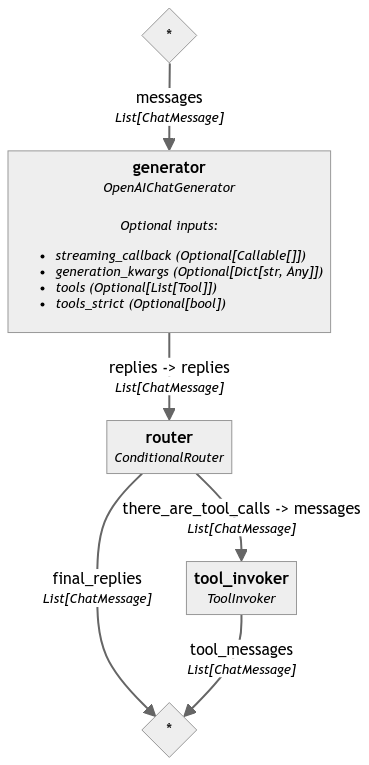

In [31]:
from haystack import Pipeline
from haystack.components.routers import ConditionalRouter
from typing import List

routes = [
    {
        "condition": "{{replies[0].tool_calls | length > 0}}",
        "output": "{{replies}}",
        "output_name": "there_are_tool_calls",
        "output_type": List[ChatMessage],
    },
    {
        "condition": "{{replies[0].tool_calls | length == 0}}",
        "output": "{{replies}}",
        "output_name": "final_replies",
        "output_type": List[ChatMessage],
    },
]

tools_pipe = Pipeline()
tools_pipe.add_component("generator", OpenAIChatGenerator(model="gpt-4o-mini", tools=[weather_tool]))
tools_pipe.add_component("router", ConditionalRouter(routes, unsafe=True))
tools_pipe.add_component("tool_invoker", ToolInvoker(tools=[weather_tool]))


tools_pipe.connect("generator.replies", "router")
tools_pipe.connect("router.there_are_tool_calls", "tool_invoker")

tools_pipe.show()

In [32]:
res=tools_pipe.run({"messages":[ChatMessage.from_user("What is the capital of Australia?")]})
print(res)

print("-"*50)

res=tools_pipe.run({"messages":[ChatMessage.from_user("What is the weather in Berlin?")]})
print(res)

{
    'router': {
        'final_replies': [
            ChatMessage(
                _role=<ChatRole.ASSISTANT: 'assistant'>,
                _content=[TextContent(text='The capital of Australia is Canberra.')],
                _meta={
                    'model': 'gpt-4o-mini-2024-07-18',
                    'index': 0,
                    'finish_reason': 'stop',
                    'usage': {'completion_tokens': 8, 'prompt_tokens': 50, 'total_tokens': 58}
                }
            )
        ]
    }
}

--------------------------------------------------

{
    'tool_invoker': {
        'tool_messages': [
            ChatMessage(
                _role=<ChatRole.TOOL: 'tool'>,
                _content=[
                    ToolCallResult(
                        result="{'temp': '7 °C', 'humidity': '46%'}",
                        origin=ToolCall(
                            tool_name='weather',
                            arguments={'location': 'Berlin'},
                            id='call_q3KA4O62IBLfOljuUKVPzdxy'
                        ),
                        error=False
                    )
                ],
                _meta={}
            )
        ]
    }
}

In this example, in case of tool calls, we end up with the raw tool invocation result, wrapped in a `ChatMessage` from tool role.
In the next example, we will see how to process this result further.

### Processing tool results with the Chat Generator

Depending on our use case and the tools involved, we might want to further process the tool's output before presenting it to the user. This can make the response more user-friendly.

In the next example, we'll pass the tool's response back to the Chat Generatpr for final processing.

In [33]:
chat_generator = OpenAIChatGenerator(model="gpt-4o-mini", tools=[weather_tool])
tool_invoker = ToolInvoker(tools=[weather_tool])

user_message = ChatMessage.from_user("What is the weather in Berlin?")

replies = chat_generator.run(messages=[user_message])["replies"]
print(f"assistant messages: {replies}")

if replies[0].tool_calls:

    tool_messages = tool_invoker.run(messages=replies)["tool_messages"]
    print(f"tool messages: {tool_messages}")

    # we pass all the messages to the Chat Generator
    messages = [user_message] + replies + tool_messages
    final_replies = chat_generator.run(messages=messages)["replies"]
    print(f"final assistant messages: {final_replies}")

assistant messages: [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[ToolCall(tool_name='weather', 
arguments={'location': 'Berlin'}, id='call_jHX0RCDHRKX7h8V9RrNs6apy')], _meta={'model': 'gpt-4o-mini-2024-07-18', 
'index': 0, 'finish_reason': 'tool_calls', 'usage': {'completion_tokens': 13, 'prompt_tokens': 50, 'total_tokens': 
63}})]

tool messages: [ChatMessage(_role=<ChatRole.TOOL: 'tool'>, _content=[ToolCallResult(result="{'temp': '2 °C', 
'humidity': '15%'}", origin=ToolCall(tool_name='weather', arguments={'location': 'Berlin'}, 
id='call_jHX0RCDHRKX7h8V9RrNs6apy'), error=False)], _meta={})]

final assistant messages: [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='The 
current weather in Berlin is 2 °C with a humidity level of 15%.')], _meta={'model': 'gpt-4o-mini-2024-07-18', 
'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 19, 'prompt_tokens': 85, 'total_tokens': 
104}})]

The assistant refines the tool's output to create a more human-readable response.

#### Using a Pipeline

The Pipeline is similar to the previous one.

We introduce a custom component, `MessageCollector`, to temporarily store the messages.

In [34]:
from typing import Any, Dict, List
from haystack import component
from haystack.core.component.types import Variadic

@component()
class MessageCollector:
    def __init__(self):
        self._messages = []

    @component.output_types(messages=List[ChatMessage])
    def run(self, messages: Variadic[List[ChatMessage]]) -> Dict[str, Any]:

        self._messages.extend([msg for inner in messages for msg in inner])
        return {"messages": self._messages}

    def clear(self):
        self._messages = []

message_collector = MessageCollector()

In [35]:
routes = [
    {
        "condition": "{{replies[0].tool_calls | length > 0}}",
        "output": "{{replies}}",
        "output_name": "there_are_tool_calls",
        "output_type": List[ChatMessage],
    },
    {
        "condition": "{{replies[0].tool_calls | length == 0}}",
        "output": "{{replies}}",
        "output_name": "final_replies",
        "output_type": List[ChatMessage],
    },
]

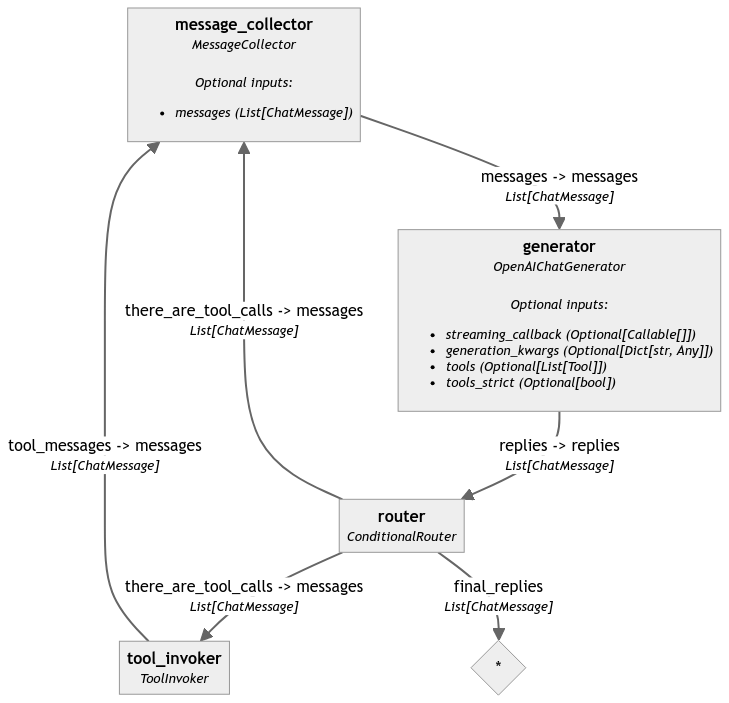

In [36]:
tool_agent = Pipeline()
tool_agent.add_component("message_collector", message_collector)
tool_agent.add_component("generator", OpenAIChatGenerator(model="gpt-4o-mini", tools=[weather_tool]))
tool_agent.add_component("router", ConditionalRouter(routes, unsafe=True))
tool_agent.add_component("tool_invoker", ToolInvoker(tools=[weather_tool]))


tool_agent.connect("message_collector", "generator.messages")
tool_agent.connect("generator.replies", "router")
tool_agent.connect("router.there_are_tool_calls", "tool_invoker")
tool_agent.connect("router.there_are_tool_calls", "message_collector")
tool_agent.connect("tool_invoker.tool_messages", "message_collector")

tool_agent.show()

In [37]:
message_collector.clear()
res=tool_agent.run({"messages":[ChatMessage.from_user("What is the capital of Australia?")]})
print(res)

print("-"*50)

message_collector.clear()
res=tool_agent.run({"messages":[ChatMessage.from_user("What is the weather in Berlin?")]})
print(res)

print("-"*50)

message_collector.clear()
res=tool_agent.run({"messages":[ChatMessage.from_user("What is the weather in Rome and Bangkok?")]})
print(res)

{
    'router': {
        'final_replies': [
            ChatMessage(
                _role=<ChatRole.ASSISTANT: 'assistant'>,
                _content=[TextContent(text='The capital of Australia is Canberra.')],
                _meta={
                    'model': 'gpt-4o-mini-2024-07-18',
                    'index': 0,
                    'finish_reason': 'stop',
                    'usage': {'completion_tokens': 8, 'prompt_tokens': 50, 'total_tokens': 58}
                }
            )
        ]
    }
}

--------------------------------------------------

{
    'router': {
        'final_replies': [
            ChatMessage(
                _role=<ChatRole.ASSISTANT: 'assistant'>,
                _content=[TextContent(text='The current weather in Berlin is 9 °C with a humidity of 40%.')],
                _meta={
                    'model': 'gpt-4o-mini-2024-07-18',
                    'index': 0,
                    'finish_reason': 'stop',
                    'usage': {'completion_tokens': 18, 'prompt_tokens': 85, 'total_tokens': 103}
                }
            )
        ]
    }
}

--------------------------------------------------

{
    'router': {
        'final_replies': [
            ChatMessage(
                _role=<ChatRole.ASSISTANT: 'assistant'>,
                _content=[
                    TextContent(
                        text='The current weather is as follows:\n\n- **Rome**: Temperature is 31 °C with 80% 
humidity.\n- **Bangkok**: Temperature is 20 °C with 23% humidity.'
                    )
                ],
                _meta={
                    'model': 'gpt-4o-mini-2024-07-18',
                    'index': 0,
                    'finish_reason': 'stop',
                    'usage': {'completion_tokens': 43, 'prompt_tokens': 147, 'total_tokens': 190}
                }
            )
        ]
    }
}

### Complex Use Case: multi-tool chat application

Next, we'll revisit the [function calling tutorial](https://haystack.deepset.ai/tutorials/40_building_chat_application_with_function_calling) using the new experimental features.

For a detailed explanation, refer to the tutorial. Here, we'll demonstrate how to implement the same behavior with the new features.

Details:
- Two tools
- One tool wraps a Haystack RAG Pipeline
- Human-in-the-loop interaction to gather details for tool calls if necessary

#### Index Documents with a Pipeline

In [38]:
from haystack import Pipeline, Document
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder

documents = [
    Document(content="My name is Jean and I live in Paris."),
    Document(content="My name is Mark and I live in Berlin."),
    Document(content="My name is Giorgio and I live in Rome."),
    Document(content="My name is Marta and I live in Madrid."),
    Document(content="My name is Harry and I live in London."),
]

document_store = InMemoryDocumentStore()

indexing_pipeline = Pipeline()
indexing_pipeline.add_component(
    instance=SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"), name="doc_embedder"
)
indexing_pipeline.add_component(instance=DocumentWriter(document_store=document_store), name="doc_writer")

indexing_pipeline.connect("doc_embedder.documents", "doc_writer.documents")

indexing_pipeline.run({"doc_embedder": {"documents": documents}})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:81: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'doc_writer': {'documents_written': 5}}

#### Build a RAG Pipeline


In [39]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator

template = """
Answer the questions based on the given context.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}
Question: {{ question }}
Answer:
"""
rag_pipe = Pipeline()
rag_pipe.add_component("embedder", SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"))
rag_pipe.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store))
rag_pipe.add_component("prompt_builder", PromptBuilder(template=template))
rag_pipe.add_component("llm", OpenAIGenerator(model="gpt-4o-mini"))

rag_pipe.connect("embedder.embedding", "retriever.query_embedding")
rag_pipe.connect("retriever", "prompt_builder.documents")
rag_pipe.connect("prompt_builder", "llm")

🚅 Components
  - embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

In [40]:
query = "Where does Mark live?"
rag_pipe.run({"embedder": {"text": query}, "prompt_builder": {"question": query}})

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'llm': {'replies': ['Mark lives in Berlin.'],
  'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 5,
     'prompt_tokens': 83,
     'total_tokens': 88}}]}}

#### Create a tool from the RAG Pipeline

In [41]:
from haystack_experimental.dataclasses import Tool

def rag_pipeline_func(query: str):
    result = rag_pipe.run({"embedder": {"text": query}, "prompt_builder": {"question": query}})

    return {"reply": result["llm"]["replies"][0]}

rag_tool = Tool(name="rag_tool",
                description="Get information about where people live",
                function=rag_pipeline_func,
                parameters={
                    "type": "object",
                    "properties": {"query": {
                        "type": "string",
                        "description": "The query to use in the search. Infer this from the user's message. It should be a question or a statement"
                        }},
                    "required": ["query"],
                })

#### Create a weather tool

In [42]:
WEATHER_INFO = {
    "Berlin": {"weather": "mostly sunny", "temperature": 7, "unit": "celsius"},
    "Paris": {"weather": "mostly cloudy", "temperature": 8, "unit": "celsius"},
    "Rome": {"weather": "sunny", "temperature": 14, "unit": "celsius"},
    "Madrid": {"weather": "sunny", "temperature": 10, "unit": "celsius"},
    "London": {"weather": "cloudy", "temperature": 9, "unit": "celsius"},
}


def get_current_weather(location: str):
    if location in WEATHER_INFO:
        return WEATHER_INFO[location]

    # fallback data
    else:
        return {"weather": "sunny", "temperature": 21.8, "unit": "fahrenheit"}

weather_tool = Tool(name="weather_tool",
                description="Get the current weather for a location",
                function=get_current_weather,
                parameters={
                    "type": "object",
                    "properties": {"location": {
                        "type": "string",
                        "description": "The location for which to get the weather"
                        }},
                    "required": ["location"],
                })

#### Chat application

In [43]:
from haystack_experimental.components.tools import ToolInvoker
from haystack_experimental.components.generators.chat.openai import OpenAIChatGenerator
from haystack_experimental.dataclasses import ChatMessage

tool_invoker = ToolInvoker(tools=[weather_tool, rag_tool])
chat_generator = OpenAIChatGenerator(model="gpt-4o-mini")


messages = [
        ChatMessage.from_system(
            """If needed, break down the user's question to simpler questions and follow-up questions that you can use with your tools.
            Don't make assumptions about what values to plug into functions. Ask for clarification if a user request is ambiguous."""
        )
    ]

while True:
    user_input = input("(type 'exit' or 'quit' to stop)\n")
    if user_input.lower() == "exit" or user_input.lower() == "quit":
        break
    messages.append(ChatMessage.from_user(user_input))
    replies = chat_generator.run(messages=messages, tools=[weather_tool, rag_tool])["replies"]
    messages.extend(replies)

    if replies[0].tool_calls:
        tool_messages = tool_invoker.run(messages=replies)["tool_messages"]
        messages.extend(tool_messages)
        # call to a chat generator to elaborate on the tool messages
        replies = chat_generator.run(messages=messages, tools=[weather_tool, rag_tool])["replies"]
        messages.extend(replies)
    print("AI: " + messages[-1].text)

(type 'exit' or 'quit' to stop)
hey!


AI: Hello! How can I assist you today?

(type 'exit' or 'quit' to stop)
I want some info on the weather


AI: Sure! Could you please specify the location for which you want to know the weather?

(type 'exit' or 'quit' to stop)
Madrid


AI: The weather in Madrid is currently sunny with a temperature of 10°C. Is there anything else you would like to 
know?

(type 'exit' or 'quit' to stop)
Ah, nice. Who lives there?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

AI: Marta lives in Madrid. If you have any more questions or need further information, feel free to ask!

(type 'exit' or 'quit' to stop)
I want to know the weather and who lives in Rome


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

AI: In Rome, the weather is currently sunny with a temperature of 14°C. Additionally, Giorgio lives there. If you 
have more questions or need further information, just let me know!

(type 'exit' or 'quit' to stop)
12+3


AI: The answer to 12 + 3 is 15. If you have more questions or need assistance with something else, feel free to 
ask!

(type 'exit' or 'quit' to stop)
quit
